In [13]:
import pandas as pd
import os

# 1. Load the Datasets
df_cuisines = pd.read_csv('tripadvisor_aggregated_cuisines.csv')

# Try loading the European obesity file, fallback to filtered_data.csv if needed
if os.path.exists('european_countries_obesity.csv'):
    df_obesity = pd.read_csv('european_countries_obesity.csv')
else:
    # Fallback if the specific file wasn't persistent
    df_raw = pd.read_csv('filtered_data.csv')
    df_obesity = df_raw[df_raw['Continent'] == 'Europe'].copy()

# 2. Prepare Obesity Data (Latest Year)
# We group by country and pick the row with the maximum year to get the most recent stats
latest_idx = df_obesity.groupby('Country')['Year'].idxmax()
df_obesity_latest = df_obesity.loc[latest_idx, ['Country', 'Obesity among adults', 'GDP per capita']]
df_obesity_latest = df_obesity_latest.rename(columns={'Obesity among adults': 'obesity_rate'})

# 3. Map Country Names
# Standardize names so they match between the two datasets
country_mapping = {
    'England': 'United Kingdom',
    'Scotland': 'United Kingdom',
    'Wales': 'United Kingdom',
    'Northern Ireland': 'United Kingdom',
    'The Netherlands': 'Netherlands',
    'Czech Republic': 'Czechia',
    'Slovakia': 'Slovak Republic'
}

df_cuisines['join_country'] = df_cuisines['country'].replace(country_mapping)

# 4. Merge
merged_df = pd.merge(
    df_cuisines,
    df_obesity_latest,
    left_on='join_country',
    right_on='Country',
    how='left'
)

# 5. Cleanup and Save
merged_df = merged_df.drop(columns=['join_country', 'Country'])
merged_df.to_csv('merged_european_restaurant_obesity.csv', index=False)

print(merged_df.head())

   country  cuisines  restaurant_count  percentage  average_rating  \
0  Austria   Afghani                 9    0.049611        3.777778   
1  Austria   African                 9    0.049611        4.611111   
2  Austria  Albanian                 1    0.005512        4.500000   
3  Austria  Algerian                 1    0.005512        4.000000   
4  Austria  American               327    1.802547        4.050459   

   total_reviews  obesity_rate  GDP per capita  
0           49.0          21.5     49865.90394  
1           83.0          21.5     49865.90394  
2            2.0          21.5     49865.90394  
3            2.0          21.5     49865.90394  
4         8182.0          21.5     49865.90394  


Top Positive Correlations with Obesity:
obesity_rate       1.000000
Kyushu cuisine     1.000000
Latvian            0.914552
Nigerian           0.877657
Kaiseki            0.770457
Fast food          0.766732
Cafe               0.711265
British            0.711131
Beijing cuisine    0.706237
Balti              0.706150
Name: obesity_rate, dtype: float64

Top Negative Correlations with Obesity:
Wine Bar                  -0.505612
Hawaiian                  -0.578254
Lombard                   -0.583229
Tibetan                   -0.634297
Hokkaido cuisine          -0.664372
Japanese sweets parlour   -0.684798
Sushi                     -0.766494
Japanese                  -0.812326
Kappo                     -1.000000
Shojin                          NaN
Name: obesity_rate, dtype: float64


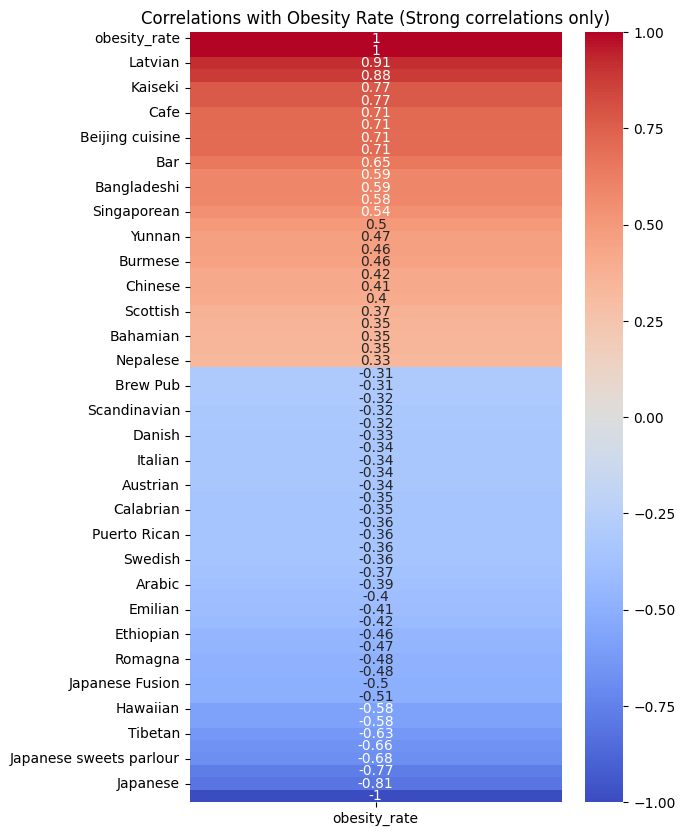

In [14]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Load the dataset
df = pd.read_csv('merged_european_restaurant_obesity.csv')

# 2. Reshape the data
# Pivot to get one row per country, with cuisines as columns
# We'll use 'percentage' as the value
pivot_df = df.pivot_table(index='country', columns='cuisines', values='percentage')

# 3. Add Obesity and GDP back (since they are constant per country)
# We can do this by grouping by country and taking the first value
country_stats = df.groupby('country')[['obesity_rate', 'GDP per capita']].first()

# Merge
analysis_df = pd.merge(pivot_df, country_stats, left_index=True, right_index=True)

# 4. Calculate Correlation Matrix
# We are interested in how everything correlates with 'obesity_rate'
correlation_matrix = analysis_df.corr()

# 5. Extract correlations specifically with Obesity Rate
obesity_correlations = correlation_matrix['obesity_rate'].sort_values(ascending=False)

# 6. Visualize
plt.figure(figsize=(6, 10))
# Filter to show only the most relevant correlations (e.g., top 10 and bottom 10) to avoid a huge heatmap
# Or just plot the column for obesity rate
target_corr = correlation_matrix[['obesity_rate']].sort_values(by='obesity_rate', ascending=False)

# Let's filter for strong correlations (abs > 0.3) to make the plot readable
strong_corr = target_corr[abs(target_corr['obesity_rate']) > 0.3]

sns.heatmap(strong_corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlations with Obesity Rate (Strong correlations only)")
plt.savefig('obesity_correlation_heatmap.png')

# 7. Print the top results
print("Top Positive Correlations with Obesity:")
print(obesity_correlations.head(10))
print("\nTop Negative Correlations with Obesity:")
print(obesity_correlations.tail(10))

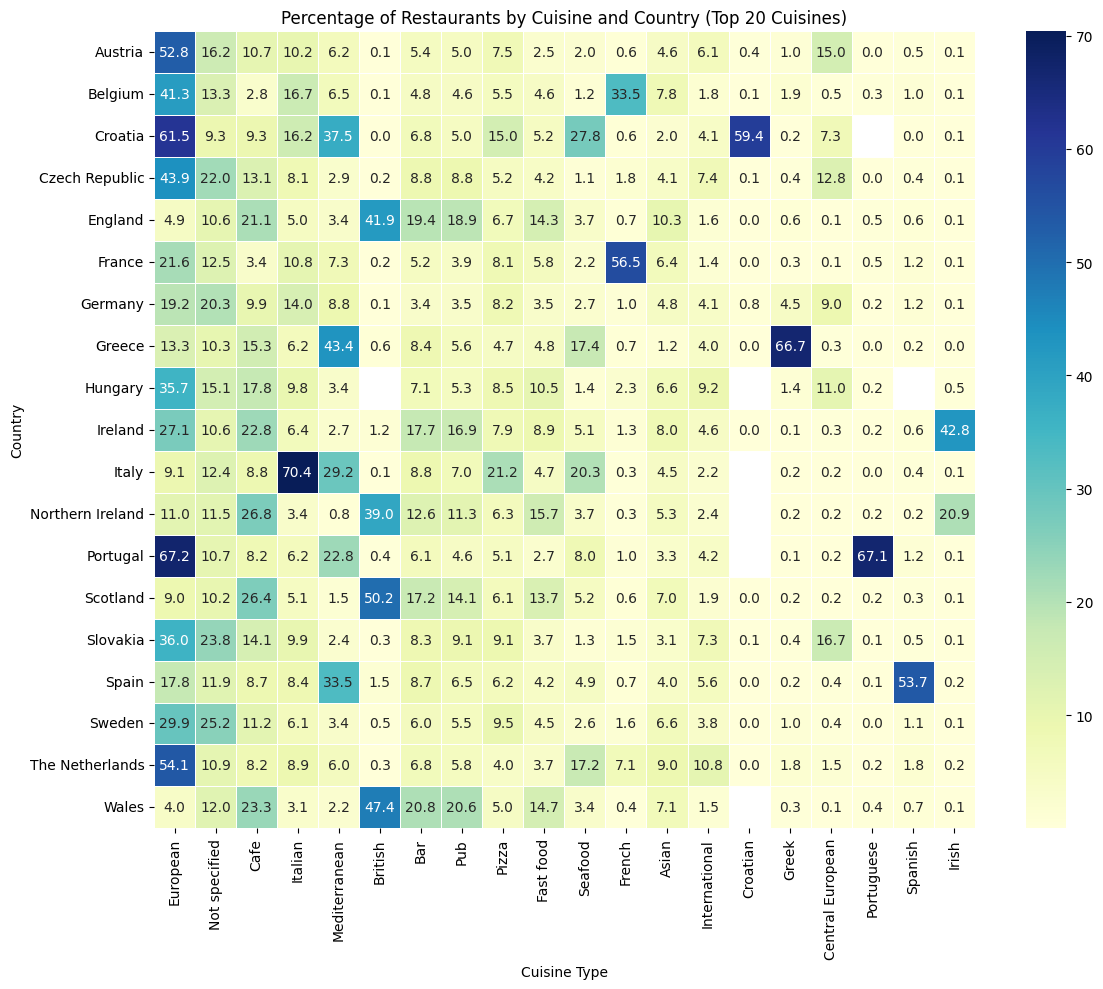

In [15]:
df = pd.read_csv('merged_european_restaurant_obesity.csv')

# 2. Pivot Data: Countries vs Cuisines
# Rows = Countries, Columns = Cuisines, Values = Percentage of Restaurants
country_cuisine_matrix = df.pivot_table(index='country', columns='cuisines', values='percentage')

# 3. Filter for Top 20 Most Common Cuisines (to keep heatmap readable)
# We take the cuisines with the highest average percentage across all countries
top_cuisines = country_cuisine_matrix.mean().sort_values(ascending=False).head(20).index
filtered_matrix = country_cuisine_matrix[top_cuisines]

# 4. Plot Heatmap 1: Cuisine Prevalence by Country
plt.figure(figsize=(12, 10))
sns.heatmap(filtered_matrix, annot=True, fmt=".1f", cmap="YlGnBu", linewidths=.5)
plt.title("Percentage of Restaurants by Cuisine and Country (Top 20 Cuisines)")
plt.xlabel("Cuisine Type")
plt.ylabel("Country")
plt.tight_layout()
plt.savefig('cuisine_prevalence_heatmap.png')

Top 5 Prevalent Cuisines per Country (Sample):
| country        | European   | Not specified   | Cafe    | Italian   | Mediterranean   | British   | Bar     | Pub     | Pizza   | Fast food   | Seafood   | French   | Asian   | International   | Croatian   | Greek    | Central European   | Portuguese   | Spanish   | Irish     |
|:---------------|:-----------|:----------------|:--------|:----------|:----------------|:----------|:--------|:--------|:--------|:------------|:----------|:---------|:--------|:----------------|:-----------|:---------|:-------------------|:-------------|:----------|:----------|
| Austria        | 52.7975    | 16.2395         | 10.683  | 10.1703   | 6.20693         | 0.0716609 | 5.37457 | 4.9887  | 7.49132 | 2.49711     | 1.97894   | 0.55675  | 4.63591 | 6.05259         | 0.407916   | 1.04184  | 14.9826            | 0.044099     | 0.479577  | 0.0992228 |
| Belgium        | 41.3028    | 13.2844         | 2.77064 | 16.7156   | 6.51376         | 0.0917431 | 4.77064 

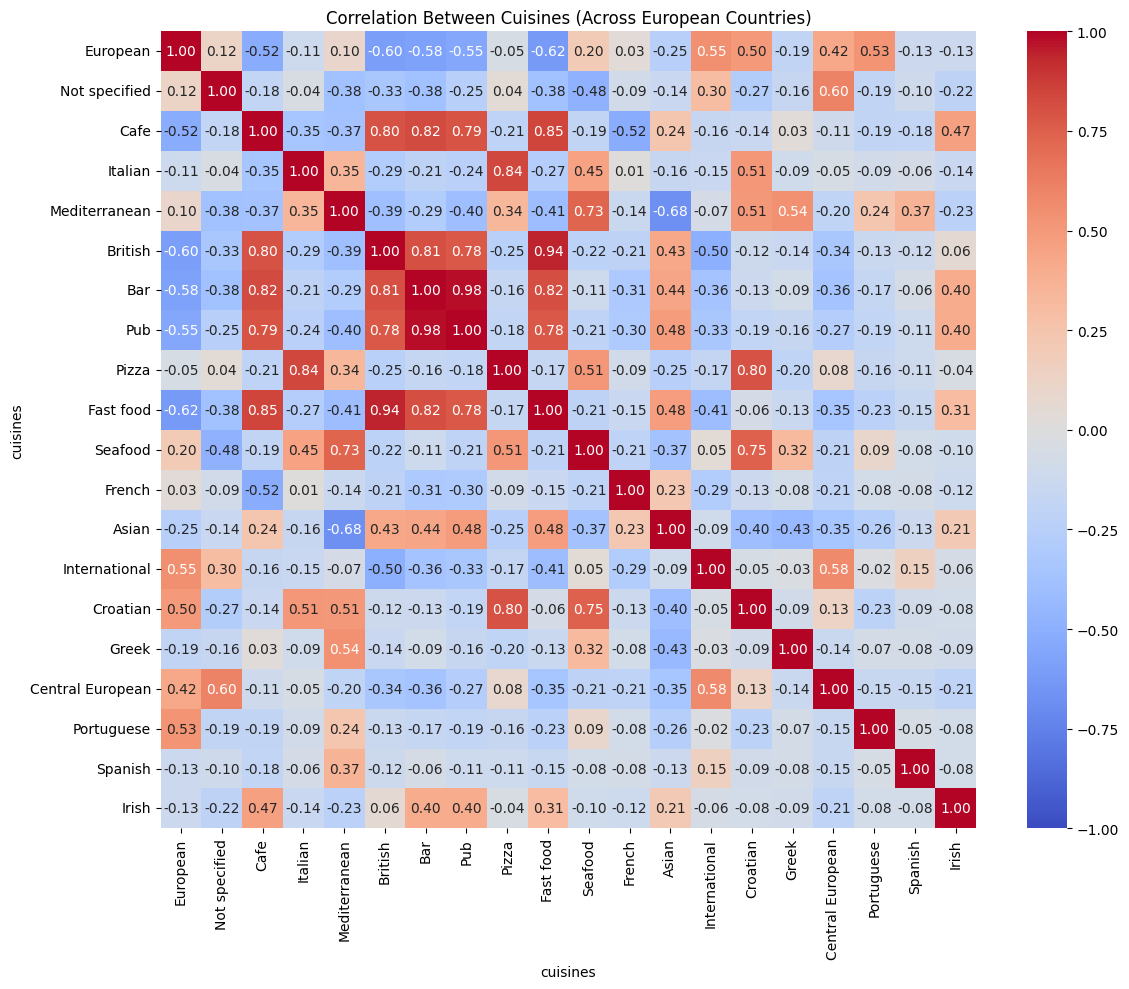

In [16]:

# 5. Plot Heatmap 2: Correlation Between Cuisines
# Do countries with more "Italian" also have more "Pizza"?
cuisine_corr = filtered_matrix.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(cuisine_corr, annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlation Between Cuisines (Across European Countries)")
plt.tight_layout()
plt.savefig('cuisine_correlation_matrix.png')

# Display the top prevalence data for inspection
print("Top 5 Prevalent Cuisines per Country (Sample):")
print(filtered_matrix.head().to_markdown(numalign="left", stralign="left"))

--- T-Test Results ---
High Mean: 26.86 | Low Mean: 23.80
T-statistic: 2.7715, P-value: 0.0131

--- OLS Regression Results ---
                            OLS Regression Results                            
Dep. Variable:           obesity_rate   R-squared:                       0.648
Model:                            OLS   Adj. R-squared:                  0.604
Method:                 Least Squares   F-statistic:                     14.73
Date:                Mon, 01 Dec 2025   Prob (F-statistic):           0.000235
Time:                        03:08:38   Log-Likelihood:                -36.182
No. Observations:                  19   AIC:                             78.36
Df Residuals:                      16   BIC:                             81.20
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.97

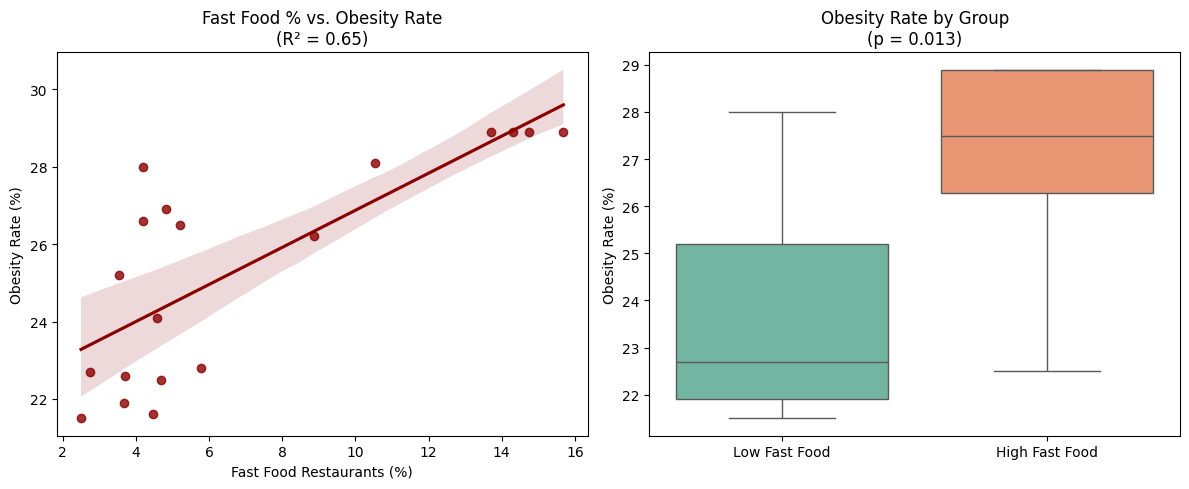

In [27]:
# 1. Prepare Data
fast_food_df = df[df['cuisines'] == 'Fast food'][['country', 'percentage', 'obesity_rate', 'GDP per capita']].copy()
fast_food_df.dropna(inplace=True)
fast_food_df.rename(columns={'percentage': 'Fast_Food_Percent'}, inplace=True)

# Define Groups
median_ff = fast_food_df['Fast_Food_Percent'].median()
fast_food_df['Group'] = np.where(fast_food_df['Fast_Food_Percent'] >= median_ff, 'High Fast Food', 'Low Fast Food')

group_high = fast_food_df[fast_food_df['Group'] == 'High Fast Food']['obesity_rate']
group_low = fast_food_df[fast_food_df['Group'] == 'Low Fast Food']['obesity_rate']

# --- T-Test ---
t_stat, p_val_t = stats.ttest_ind(group_high, group_low)
cohens_d = (group_high.mean() - group_low.mean()) / (np.sqrt((group_high.std()**2 + group_low.std()**2) / 2))

print(f"--- T-Test Results ---")
print(f"High Mean: {group_high.mean():.2f} | Low Mean: {group_low.mean():.2f}")
print(f"T-statistic: {t_stat:.4f}, P-value: {p_val_t:.4f}")

# --- Regression ---
X = fast_food_df[['Fast_Food_Percent', 'GDP per capita']]
y = fast_food_df['obesity_rate']
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
print("\n--- OLS Regression Results ---")
print(model.summary())

# --- Visualizations (FIXED) ---
plt.figure(figsize=(12, 5))

# Plot 1: Scatter
plt.subplot(1, 2, 1)
sns.regplot(x='Fast_Food_Percent', y='obesity_rate', data=fast_food_df, color='darkred', ci=95)
plt.title(f"Fast Food % vs. Obesity Rate\n(R² = {model.rsquared:.2f})")
plt.xlabel("Fast Food Restaurants (%)")
plt.ylabel("Obesity Rate (%)")

# Plot 2: Box Plot (Corrected for Warning)
plt.subplot(1, 2, 2)
# FIX IS HERE: Added hue='Group' and legend=False
sns.boxplot(x='Group', y='obesity_rate', hue='Group', data=fast_food_df, palette="Set2", legend=False)
plt.title(f"Obesity Rate by Group\n(p = {p_val_t:.3f})")
plt.ylabel("Obesity Rate (%)")
plt.xlabel("")

plt.tight_layout()
plt.show()

--- Top 10 Cuisines Positively Correlated with Obesity ---
Kyushu cuisine     1.000000
Latvian            0.914552
Nigerian           0.877657
Kaiseki            0.770457
Fast food          0.766732
Cafe               0.711265
British            0.711131
Beijing cuisine    0.706237
Balti              0.706150
Bar                0.654785
Name: obesity_rate, dtype: float64

--- Top 10 Cuisines Negatively Correlated with Obesity ---
Wine Bar                  -0.505612
Hawaiian                  -0.578254
Lombard                   -0.583229
Tibetan                   -0.634297
Hokkaido cuisine          -0.664372
Japanese sweets parlour   -0.684798
Sushi                     -0.766494
Japanese                  -0.812326
Kappo                     -1.000000
Shojin                          NaN
Name: obesity_rate, dtype: float64


C:\Users\sivam\AppData\Local\Temp\ipykernel_42832\432486089.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_corr.values, y=top_corr.index, palette='coolwarm')


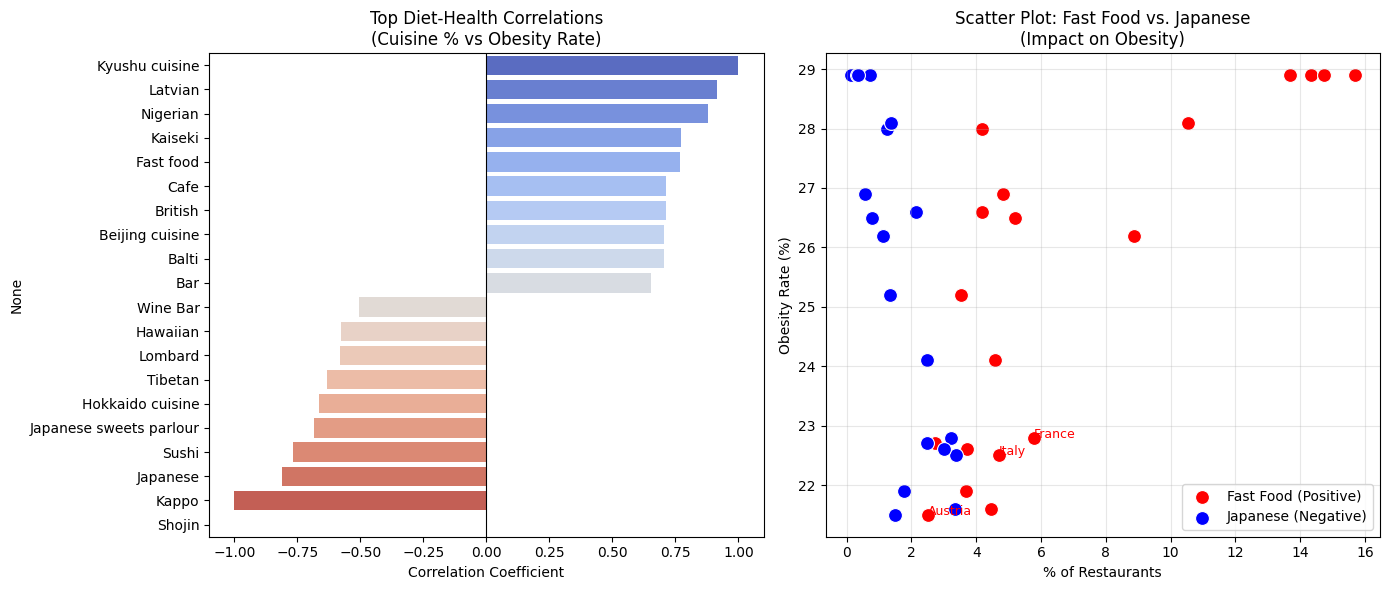

In [28]:
# 2. Pivot: Countries x Cuisines
# We want to see how the percentage of each cuisine relates to the obesity rate
cuisine_matrix = df.pivot_table(index='country', columns='cuisines', values='percentage')

# 3. Add Obesity Rate
# Get obesity rate per country (it's the same for all rows of a country)
obesity_rates = df.groupby('country')['obesity_rate'].mean()
analysis_df = pd.merge(cuisine_matrix, obesity_rates, left_index=True, right_index=True)

# 4. Calculate Correlations
# We correlate every cuisine column with the 'obesity_rate' column
correlations = analysis_df.corr()['obesity_rate'].drop('obesity_rate') # Drop self-correlation
correlations = correlations.sort_values(ascending=False)

# 5. Display Top Correlations
print("--- Top 10 Cuisines Positively Correlated with Obesity ---")
print(correlations.head(10))
print("\n--- Top 10 Cuisines Negatively Correlated with Obesity ---")
print(correlations.tail(10))

# 6. Visualizations
plt.figure(figsize=(14, 6))

# Plot 1: Bar Chart of Top Correlations
plt.subplot(1, 2, 1)
# Combine top 10 positive and bottom 10 negative
top_corr = pd.concat([correlations.head(10), correlations.tail(10)])
sns.barplot(x=top_corr.values, y=top_corr.index, palette='coolwarm')
plt.title('Top Diet-Health Correlations\n(Cuisine % vs Obesity Rate)')
plt.xlabel('Correlation Coefficient')
plt.axvline(0, color='black', linewidth=0.8)

# Plot 2: Scatter Plots for Key Examples
# We'll plot the strongest Positive (e.g., Fast Food) and Negative (e.g., Japanese)
plt.subplot(1, 2, 2)
sns.scatterplot(x=analysis_df['Fast food'], y=analysis_df['obesity_rate'], 
                color='red', label='Fast Food (Positive)', s=100)
sns.scatterplot(x=analysis_df['Japanese'], y=analysis_df['obesity_rate'], 
                color='blue', label='Japanese (Negative)', s=100)

# Add country labels for context
for country in analysis_df.index:
    # Label a few points to avoid clutter (e.g., extremes)
    if country in ['United Kingdom', 'Italy', 'France', 'Malta', 'Austria']:
        plt.text(analysis_df.loc[country, 'Fast food'], analysis_df.loc[country, 'obesity_rate'], 
                 country, fontsize=9, color='red')

plt.title('Scatter Plot: Fast Food vs. Japanese\n(Impact on Obesity)')
plt.xlabel('% of Restaurants')
plt.ylabel('Obesity Rate (%)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('diet_health_correlations.png')
plt.show()

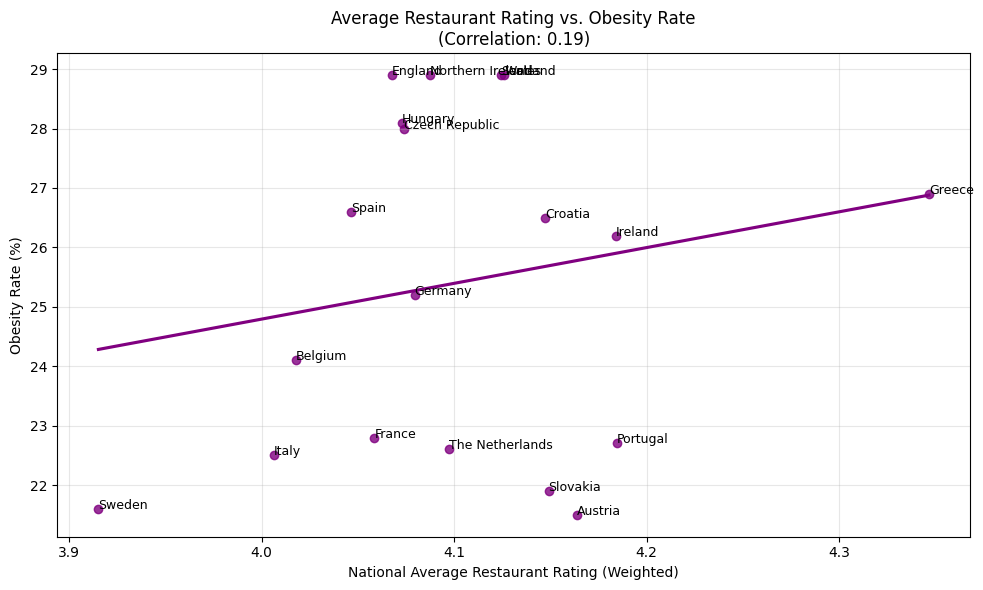

Correlation coefficient: 0.1901


In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1. Define Weighted Average Function
def weighted_avg(x):
    if x['restaurant_count'].sum() == 0:
        return np.nan
    return np.average(x['average_rating'], weights=x['restaurant_count'])

# 2. Calculate National Stats (Fixing the Warning)
# We select only the columns we need for the calculation
cols_needed = ['restaurant_count', 'average_rating', 'obesity_rate']

# Group by country and select specific columns
# This avoids the ambiguity of including the grouping key in the applied dataframe
country_stats = df.groupby('country')[cols_needed].apply(lambda x: pd.Series({
    'national_avg_rating': weighted_avg(x),
    'obesity_rate': x['obesity_rate'].mean()
})).reset_index()

# 3. Correlation & Visualization
correlation = country_stats['national_avg_rating'].corr(country_stats['obesity_rate'])

plt.figure(figsize=(10, 6))
sns.regplot(x='national_avg_rating', y='obesity_rate', data=country_stats, color='purple', ci=None)

for i, row in country_stats.iterrows():
    plt.text(row['national_avg_rating'], row['obesity_rate'], row['country'], fontsize=9)

plt.title(f'Average Restaurant Rating vs. Obesity Rate\n(Correlation: {correlation:.2f})')
plt.xlabel('National Average Restaurant Rating (Weighted)')
plt.ylabel('Obesity Rate (%)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Correlation coefficient: {correlation:.4f}")

--- Top 10 Cuisines Positively Correlated with GDP ---
Kappo             1.000000
Kyushu cuisine    1.000000
Singaporean       0.709645
Thai              0.653182
Asian             0.651442
Afghani           0.632183
Deli              0.622327
Chinese           0.616845
Malaysian         0.605826
Irish             0.605711
Name: GDP per capita, dtype: float64

--- Top 10 Cuisines Negatively Correlated with GDP ---
Mediterranean    -0.546406
Fruit parlours   -0.548995
Xinjiang         -0.573933
Barbecue         -0.598427
Yunnan           -0.638728
Norwegian        -0.725452
Lombard          -0.779880
Puerto Rican     -0.918991
Kyoto cuisine    -0.955324
Shojin                 NaN
Name: GDP per capita, dtype: float64


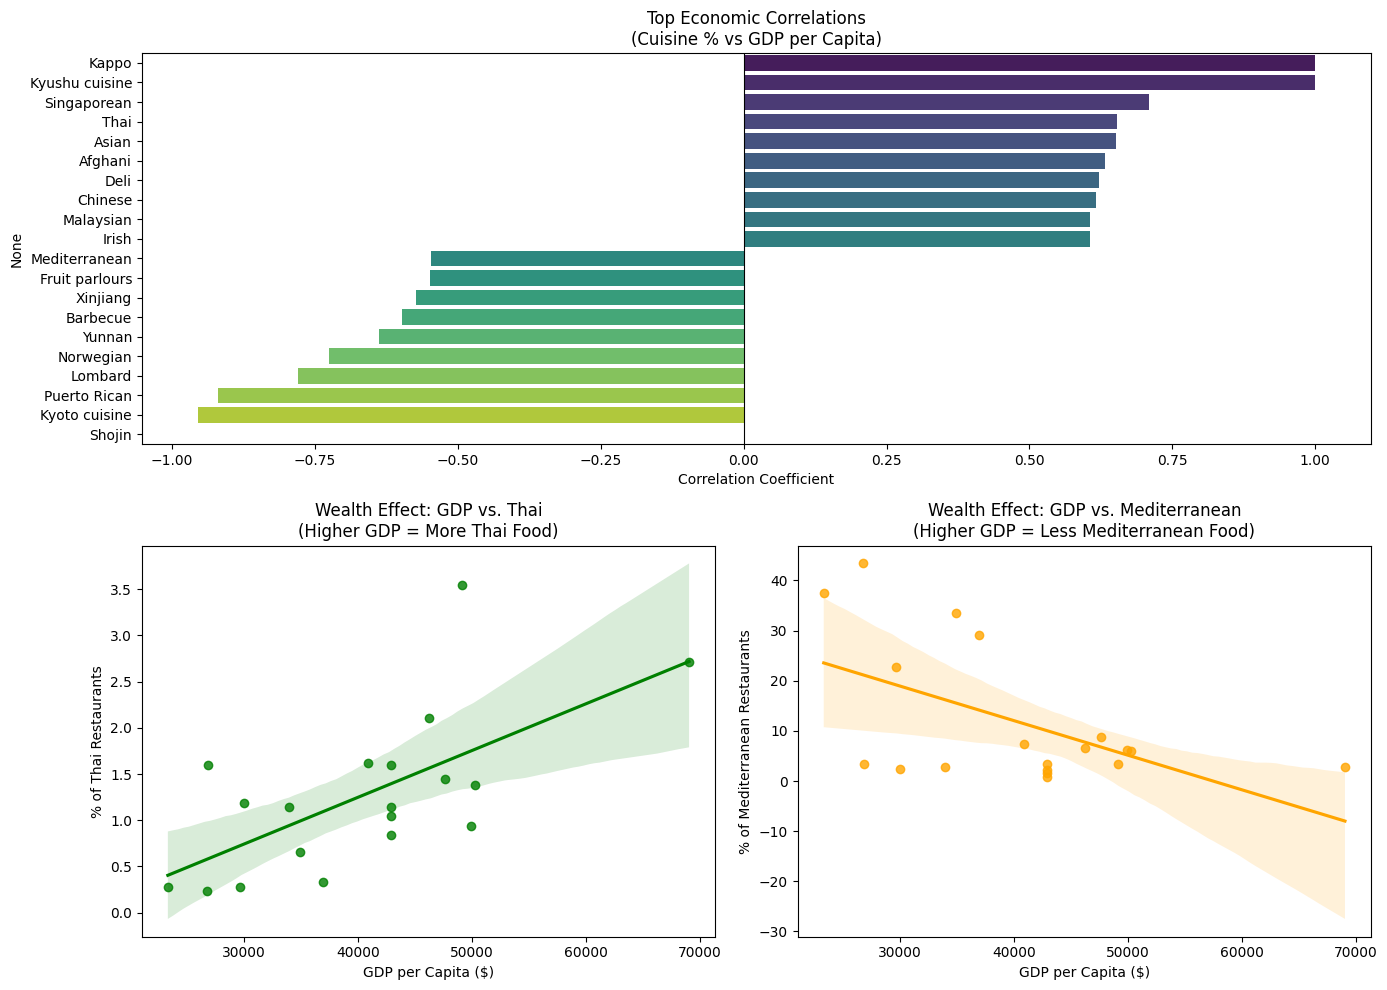

In [30]:
# 2. Pivot: Countries x Cuisines
# We want to see how the percentage of each cuisine relates to GDP
cuisine_matrix = df.pivot_table(index='country', columns='cuisines', values='percentage')

# 3. Add GDP per Capita
# Get GDP per country (it's the same for all rows of a country)
country_gdp = df.groupby('country')['GDP per capita'].mean()
analysis_df = pd.merge(cuisine_matrix, country_gdp, left_index=True, right_index=True)

# 4. Calculate Correlations
# We correlate every cuisine column with the 'GDP per capita' column
correlations = analysis_df.corr()['GDP per capita'].drop('GDP per capita') # Drop self-correlation
correlations = correlations.sort_values(ascending=False)

# 5. Display Top Correlations
print("--- Top 10 Cuisines Positively Correlated with GDP ---")
print(correlations.head(10))
print("\n--- Top 10 Cuisines Negatively Correlated with GDP ---")
print(correlations.tail(10))

# 6. Visualizations
plt.figure(figsize=(14, 10))

# Plot 1: Bar Chart of Top Correlations
plt.subplot(2, 1, 1)
# Combine top 10 positive and bottom 10 negative
top_corr = pd.concat([correlations.head(10), correlations.tail(10)])

# Use hue to fix warning, and remove legend manually if present
ax = sns.barplot(x=top_corr.values, y=top_corr.index, hue=top_corr.index, palette='viridis', dodge=False)
if ax.legend_:
    ax.legend_.remove() 

plt.title('Top Economic Correlations\n(Cuisine % vs GDP per Capita)')
plt.xlabel('Correlation Coefficient')
plt.axvline(0, color='black', linewidth=0.8)

# Plot 2: Scatter Plots for Key Examples
# Plot the strongest Positive (e.g., Thai/Asian) and Negative (e.g., Mediterranean)
# We pick one strong positive and one strong negative to show the trend
strongest_pos = correlations.index[0] # e.g. Kappo or Singaporean, maybe pick a more common one if those are rare
strongest_neg = correlations.index[-1] # e.g. Kyoto cuisine or Puerto Rican

# Let's pick 'Thai' and 'Mediterranean' as they are more common/representative if they are in top list
# Or just pick the mathematical top 1. Let's check the list.
# Based on previous output: Thai was 0.65, Mediterranean was -0.54. These are good examples.
# Let's use the actual top 1 for accuracy, but handle if they are niche.
pos_cuisine = 'Thai' if 'Thai' in correlations.head(10) else correlations.index[0]
neg_cuisine = 'Mediterranean' if 'Mediterranean' in correlations.tail(10) else correlations.index[-1]

plt.subplot(2, 2, 3)
sns.regplot(x=analysis_df['GDP per capita'], y=analysis_df[pos_cuisine], 
                color='green', label=f'{pos_cuisine} (Positive)')
plt.title(f'Wealth Effect: GDP vs. {pos_cuisine}\n(Higher GDP = More {pos_cuisine} Food)')
plt.xlabel('GDP per Capita ($)')
plt.ylabel(f'% of {pos_cuisine} Restaurants')

plt.subplot(2, 2, 4)
sns.regplot(x=analysis_df['GDP per capita'], y=analysis_df[neg_cuisine], 
                color='orange', label=f'{neg_cuisine} (Negative)')
plt.title(f'Wealth Effect: GDP vs. {neg_cuisine}\n(Higher GDP = Less {neg_cuisine} Food)')
plt.xlabel('GDP per Capita ($)')
plt.ylabel(f'% of {neg_cuisine} Restaurants')

plt.tight_layout()
plt.savefig('gdp_cuisine_correlations.png')
plt.show()